### Bibliotecas

In [1]:
import numpy as np
import rasterio
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go


### Parâmetros

In [4]:
# Caminho para o arquivo do MDT
filepath = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP_corrigido_projetado.tif'

In [ ]:
# Função para carregar o MDT
def load_mdt(filepath):
    with rasterio.open(filepath) as src:
        mdt = src.read(1)
        nodata = src.nodata
        profile = src.profile
    return mdt, nodata, profile

# Função para tratar valores nodata
def handle_nodata(mdt, nodata):
    if nodata is not None:
        mdt[mdt == nodata] = np.nan
    return mdt

# Função para calcular as estatísticas descritivas
def calculate_statistics(mdt):
    mdt_flat = mdt.flatten()
    mdt_flat = mdt_flat[~np.isnan(mdt_flat)]  # Remover NaNs para análise
    stats = {
        'mean': np.mean(mdt_flat),
        'median': np.median(mdt_flat),
        'std_dev': np.std(mdt_flat),
        'variance': np.var(mdt_flat),
        'coeff_var': np.std(mdt_flat) / np.mean(mdt_flat),
        'skewness': skew(mdt_flat),
        'kurtosis': kurtosis(mdt_flat),
        'max_value': np.max(mdt_flat)
    }
    return stats

# Função para calcular a declividade
def calculate_slope(mdt, profile):
    x, y = np.gradient(mdt, profile['transform'][0], profile['transform'][4])
    slope = np.sqrt(x**2 + y**2)
    return slope

# Função para visualizar o MDT, declividade e histograma das elevações
def visualize_data(mdt, slope):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Aumentar a área dos gráficos
    
    ax[0].imshow(mdt, cmap='terrain')
    ax[0].set_title('MDT')
    
    ax[1].imshow(slope, cmap='viridis')
    ax[1].set_title('Declividade')
    
    ax[2].hist(mdt.flatten(), bins=50, color='grey', edgecolor='black')
    ax[2].set_title('Histograma de Elevações')
    
    plt.tight_layout()  # Ajustar layout para melhor visualização
    plt.show()

# Função para verificar as dimensões e valores dos eixos X e Y
def check_coordinates(profile):
    width = profile['width']
    height = profile['height']
    transform = profile['transform']
    
    x = np.arange(0, width) * transform[0] + transform[2]
    y = np.arange(0, height) * transform[4] + transform[5]
    
    print(f"Dimensões do DEM: {width} x {height}")
    print(f"Coordenadas X variam de {x.min()} a {x.max()}")
    print(f"Coordenadas Y variam de {y.min()} a {y.max()}")

In [18]:
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np

def visualize_3d_geo(mdt, profile):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    width = profile['width']
    height = profile['height']
    transform = profile['transform']
    crs = profile['crs']  # Deve estar presente e corretamente definido (ex: EPSG:31983, EPSG:32723 etc.)

    # Gerar grid de coordenadas UTM
    x = np.arange(0, width) * transform[0] + transform[2]
    y = np.arange(0, height) * transform[4] + transform[5]
    x, y = np.meshgrid(x, y)

    # Converter UTM para Latitude/Longitude
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    lon, lat = transformer.transform(x, y)

    # Matriz de elevação
    z = np.nan_to_num(mdt)

    # Subamostragem para melhorar desempenho
    stride = 5
    lon = lon[::stride, ::stride]
    lat = lat[::stride, ::stride]
    z = z[::stride, ::stride]

    # Clipping para evitar extremos visuais
    z = np.clip(z, 0, 1200)

    # Visualização
    surf = ax.plot_surface(lon, lat, z, cmap='terrain', edgecolor='none',
                           alpha=0.95, shade=True, antialiased=True)

    ax.set_title('Visualização 3D do MDT com Coordenadas Geográficas')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Elevação (m)')
    ax.view_init(elev=45, azim=135)

    plt.tight_layout()
    plt.show()





{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 1597, 'height': 2399, 'count': 1, 'crs': CRS.from_wkt('PROJCS["SIRGAS 2000 / UTM zone 23S",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4674"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-45],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","31983"]]'), 'transform': Affine(29.960614723432364, 0.0, 313302.03886734426,
       0.0, -29.960614723432364, 7416368.206745678), 'blockxsize': 1597, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
Estatísticas Descri

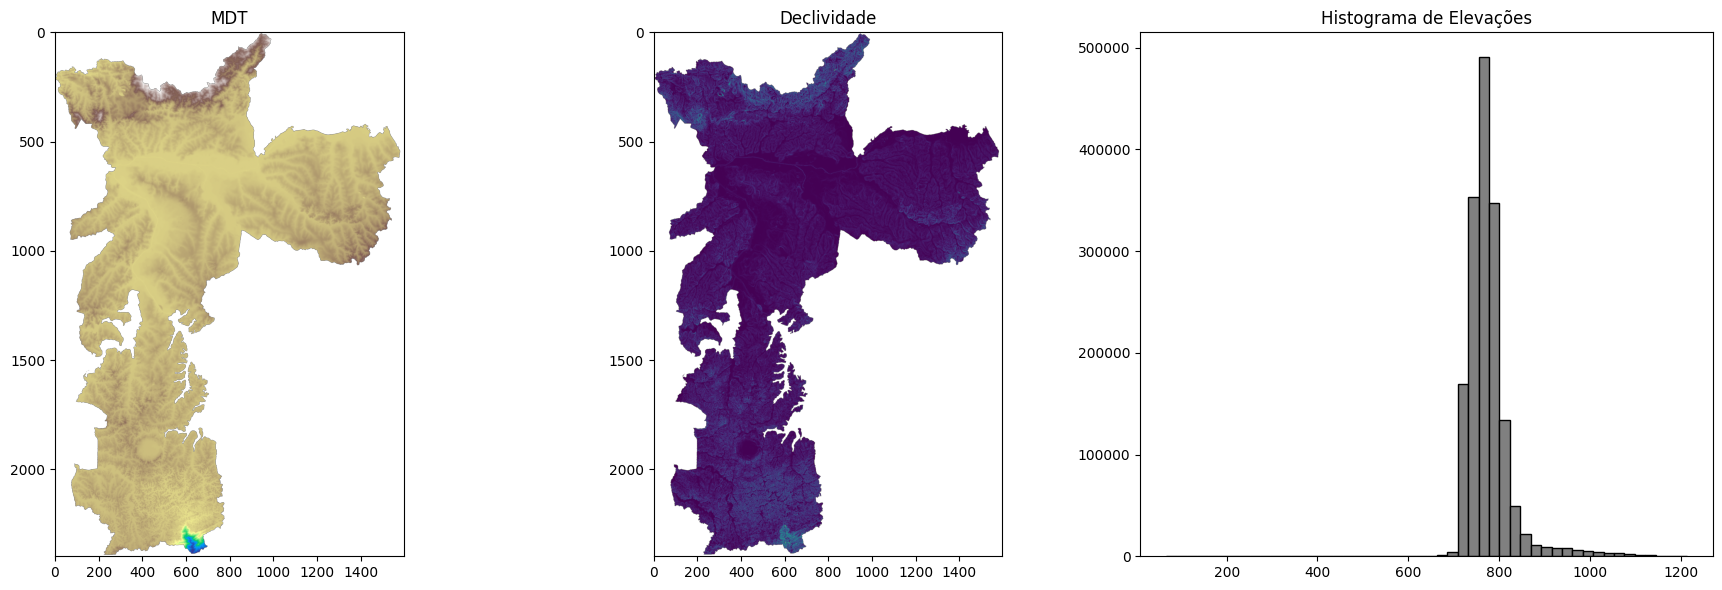

Dimensões do DEM: 1597 x 2399
Coordenadas X variam de 313302.03886734426 a 361119.17996594234
Coordenadas Y variam de 7344522.652638887 a 7416368.206745678


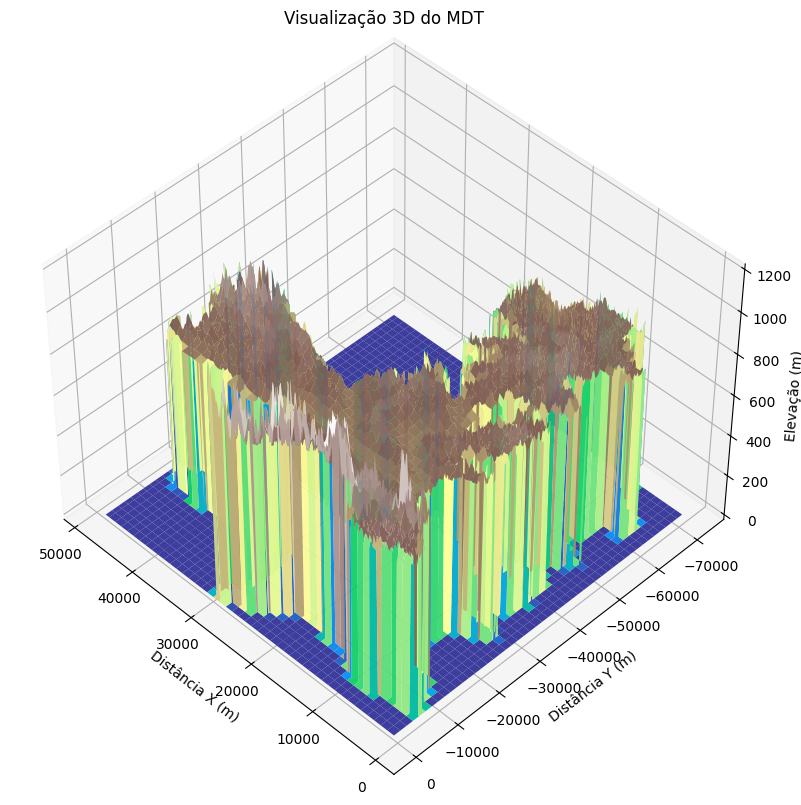

In [20]:

# Função principal
def main():
    # Caminho para o arquivo do MDT
    #filepath = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/My Drive/Produção novo DEM SP/Novo_DEM_SP.tif'
    #'/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP.tif'
    
    # Carregar o MDT
    mdt, nodata, profile = load_mdt(filepath)
    print(profile)
    
    # Tratar valores nodata
    mdt = handle_nodata(mdt, nodata)
    
    # Calcular estatísticas descritivas
    stats = calculate_statistics(mdt)
    print("Estatísticas Descritivas:")
    for key, value in stats.items():
        print(f"{key}: {value:.3f}")
    
    # Calcular declividade
    slope = calculate_slope(mdt, profile)
    
    # Visualizar MDT, declividade e histograma
    visualize_data(mdt, slope)
    
    # Verificar coordenadas
    check_coordinates(profile)
    
    # Visualizar MDT em 3D
    visualize_3d(mdt, profile)

if __name__ == "__main__":
    main()

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 1597, 'height': 2399, 'count': 1, 'crs': CRS.from_wkt('PROJCS["SIRGAS 2000 / UTM zone 23S",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4674"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-45],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","31983"]]'), 'transform': Affine(29.960614723432364, 0.0, 313302.03886734426,
       0.0, -29.960614723432364, 7416368.206745678), 'blockxsize': 1597, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


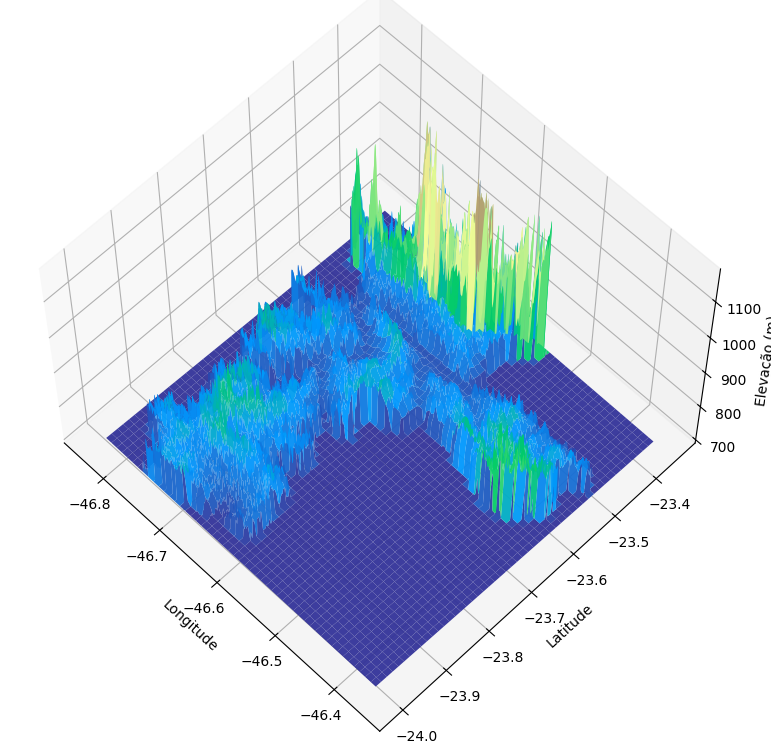

In [57]:
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter

 # Carregar o MDT
mdt, nodata, profile = load_mdt(filepath)
print(profile)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

width = profile['width']
height = profile['height']
transform = profile['transform']
crs = profile['crs']  # Deve estar presente e corretamente definido (ex: EPSG:31983, EPSG:32723 etc.)

# Gerar grid de coordenadas UTM
x = np.arange(0, width) * transform[0] + transform[2]
y = np.arange(0, height) * transform[4] + transform[5]
x, y = np.meshgrid(x, y)

# Converter UTM para Latitude/Longitude
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(x, y)

# Matriz de elevação
z = np.nan_to_num(mdt)

# Subamostragem para melhorar desempenho
#stride = 5
#lon = lon[::stride, ::stride]
#lat = lat[::stride, ::stride]
#z = z[::stride, ::stride]

# Clipping para evitar extremos visuais
z = np.clip(z, 700, 1200)

z_smooth = gaussian_filter(z, sigma=2)

# Visualização
norm = Normalize(vmin=700, vmax=1200)
surf = ax.plot_surface(lon, lat, z_smooth, cmap='terrain', edgecolor='none',
                           alpha=0.95, shade=True, norm=norm, antialiased=True)

#fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Elevação (m)')
#ax.set_title('Visualização 3D do MDT com Coordenadas Geográficas')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.set_zlim(700, 1200)
ax.set_zlabel('Elevação (m)')
ax.view_init(elev=60, azim=-45)

#plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.87, top=0.95, bottom=0.05)
plt.show()

In [3]:
# This is based on the tutorial hosted at https://github.com/mdbartos/pysheds?tab=readme-ov-file
# Read elevation raster
# ----------------------------
from pysheds.grid import Grid

grid = Grid.from_raster(filepath)
dem = grid.read_raster(filepath)

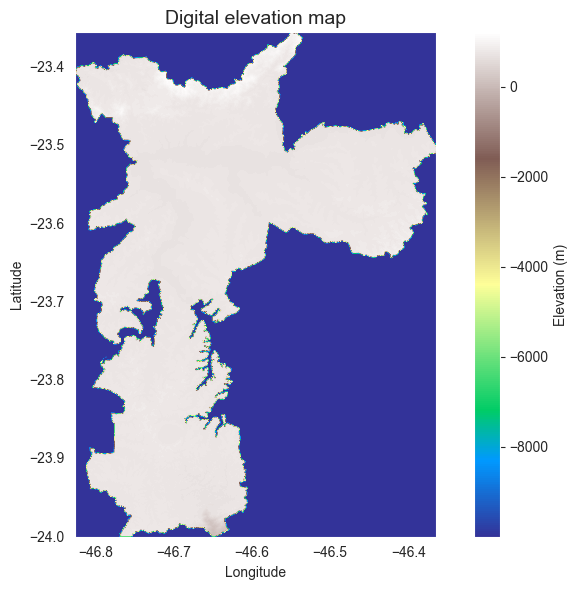

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [6]:
import rasterio

# Função para carregar o MDT
def load_mdt(filepath):
    with rasterio.open(filepath) as src:
        mdt = src.read(1)
        nodata = src.nodata
        profile = src.profile
    return mdt, nodata, profile

# Função para tratar valores nodata
def handle_nodata(mdt, nodata):
    if nodata is not None:
        mdt[mdt == nodata] = np.nan
    return mdt

In [7]:
# Carregar o MDT
mdt, nodata, profile = load_mdt(filepath)
    
# Tratar valores nodata
mdt = handle_nodata(mdt, nodata)

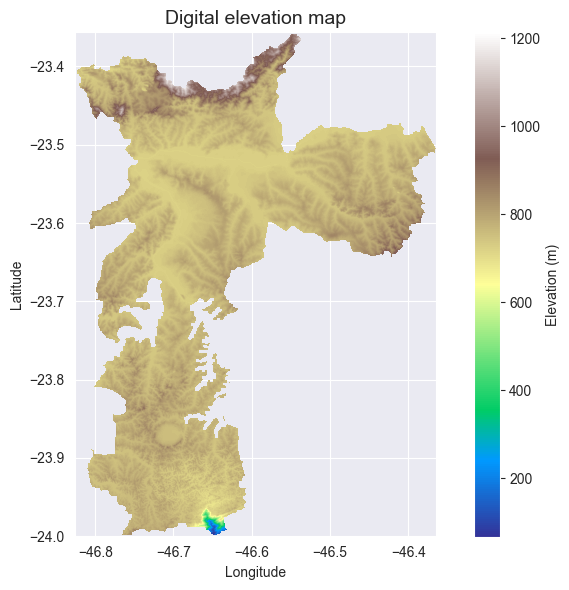

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(mdt, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [18]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Caminho para o raster original
input_raster = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP_corrigido.tif'
output_raster = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP_corrigido_projetado.tif'

# Definir o sistema de coordenadas de destino (exemplo: EPSG:4326 - WGS 84)
dst_crs = 'EPSG:31983'

# Abrir o raster original
with rasterio.open(input_raster) as src:
    # Calcular a transformação necessária para o novo CRS
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # Atualizar o perfil do raster para corresponder ao novo CRS
    profile = src.profile
    profile.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Abrir o arquivo de saída para salvar o raster reprojetado
    with rasterio.open(output_raster, 'w', **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

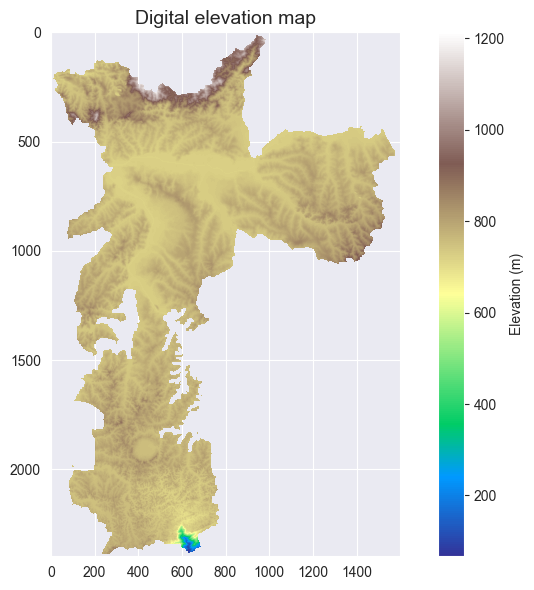

In [19]:
import rasterio

with rasterio.open(output_raster) as src:
    mdt = src.read(1)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(mdt, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.tight_layout()

In [9]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [10]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

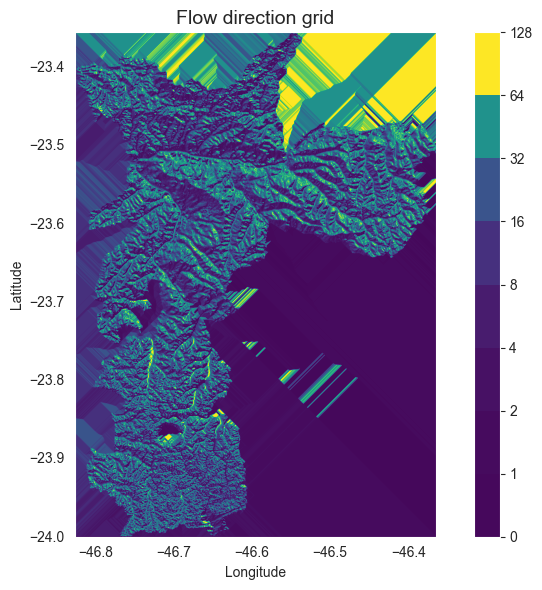

In [11]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [12]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

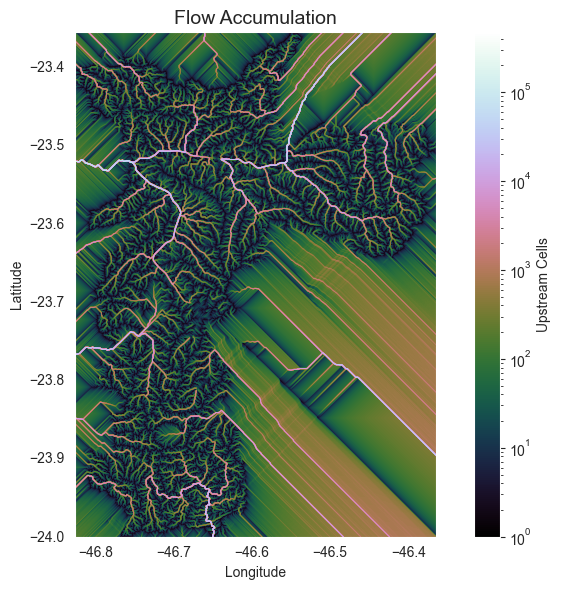

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [14]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

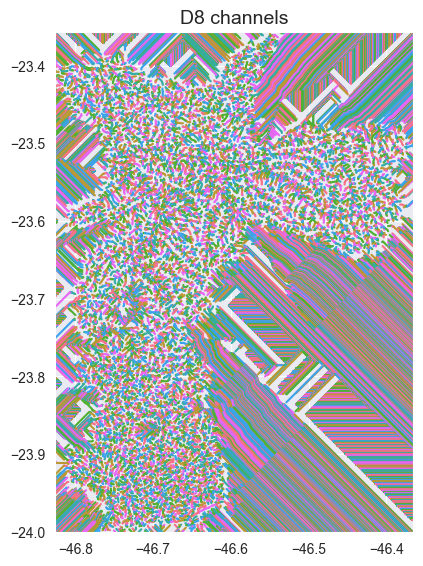

In [15]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [18]:
import rasterio
import numpy as np

# Função para tratar valores nodata
def handle_nodata(mdt, nodata):
    if nodata is not None:
        mdt[mdt == nodata] = np.nan
    return mdt

# Carregar o arquivo raster original
input_filepath = filepath
output_filepath =  '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP_corrigido.tif'

with rasterio.open(input_filepath) as src:
    mdt = src.read(1)  # Ler a primeira banda do raster
    nodata = src.nodata  # Obter o valor nodata original
    mdt_corrigido = handle_nodata(mdt, nodata)  # Tratar os valores nodata

    # Configurar o perfil de metadados para o arquivo de saída
    profile = src.profile
    profile.update(
        dtype=rasterio.float32,  # Certifique-se de que o tipo de dado esteja correto
        nodata=np.nan  # Definir o novo valor nodata
    )

    # Gravar o raster corrigido em um novo arquivo
    with rasterio.open(output_filepath, 'w', **profile) as dst:
        dst.write(mdt_corrigido.astype(rasterio.float32), 1)  # Escrever a banda corrigida
